In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, classification_report
from sklearn.manifold import TSNE

import xgboost as xgb

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
def feature_importance(X, y, model_instance, feature_names, fi_name):
    #takes in features (X) and classess (y), model, column names for features in X, and name of attribute for feature importance
    #returns dictionary of feature names and coef/feature importance values
    
    feature_importance_dic = {}
    
    model_instance.fit(X, y)
    
    if fi_name == 'coef':
        coef = model_instance.coef_[0]
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'feature_importance':
        coef = model_instance.feature_importances_
        feature_importance_dic = dict(zip(feature_names, coef))
    if fi_name == 'none':
        coef = np.zeros(len(feature_names))
        feature_importance_dic = dict(zip(feature_names, coef))
    
    return feature_importance_dic

In [3]:
def classification_pipeline(X, y, cv_instance, model_instance, feature_names, fi_name):
    
    #scale data
    data_scaled = scaler.fit_transform(X)
    
    #generate cross-val sets
    cv = list(cv_instance.split(data_scaled, y))
    
    #predict class and predict probability 
    y_pred = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict')
    y_pred_prob = cross_val_predict(model_instance, data_scaled, y, cv=cv, method='predict_proba')
    
    #generate confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    print('Confusion matrix:', conf_mat)
    
    #generate ROC_AUC
    ROC_AUC = metrics.roc_auc_score(y, y_pred_prob[:,1])
    print("ROC_AUC: ", ROC_AUC)
    
    # generate additional metrics
    recall = metrics.recall_score(y,y_pred)
    precision = metrics.precision_score(y,y_pred)
    accuracy = metrics.accuracy_score(y,y_pred)
    F1 = metrics.f1_score(y,y_pred)
    print("Sensitivity/Recall (TPR): ",recall)
    print("Precision (PPV): ", precision)
    print("Accuracy: ", accuracy)
    print("F1:", F1)
    
    #determine feature importance
    feature_dic = feature_importance(data_scaled, y, model_instance, feature_names, fi_name)
    
    #create dic
    data_dic = {}
    data_dic['y_pred'] = y_pred
    data_dic['y_pred_prob'] = y_pred_prob
    data_dic['conf_mat'] = conf_mat
    data_dic['ROC_AUC'] = ROC_AUC
    data_dic['recall'] = recall
    data_dic['precision'] = precision
    data_dic['accuracy'] = accuracy
    data_dic['F1'] = F1
    
    data_dic = {**data_dic, **feature_dic}
    
    return data_dic

In [4]:
path = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Escalation/Phillips/Combined.xlsx'

In [5]:
#original file has multiple sheets (for different FIFI types)
whole_file = pd.ExcelFile(path)

print(whole_file.sheet_names)

combined_data = pd.DataFrame()
for sheet_name in whole_file.sheet_names:
    print(sheet_name)

    if sheet_name != 'days2crit':
        
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        #sheet_data['feature_type'] = [sheet_name]*sheet_data.shape[0]
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
           16, 17, 18, 19, 20, 21, 22, 23]]

        for index, row in sheet_data.iterrows():
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_5')] = row.dropna()[-5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_4')] = row.dropna()[-4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_3')] = row.dropna()[-3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_2')] = row.dropna()[-2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_minus_1')] = row.dropna()[-1]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus1')] = row.dropna()[2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus2')] = row.dropna()[3]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus3')] = row.dropna()[4]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus4')] = row.dropna()[5]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_plus5')] = row.dropna()[6]
            
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_first')] = row[2]
            sheet_data.loc[sheet_data.index[index], str(sheet_name + '_last')] = row.dropna()[-1]
            
        sheet_data = sheet_data[['Animal', 'Group', 
                                 str(sheet_name + '_plus1'), \
                                str(sheet_name + '_plus2'), \
                                str(sheet_name + '_plus3'), \
                                str(sheet_name + '_plus4'), \
                                str(sheet_name + '_plus5'), \
                                 str(sheet_name + '_minus_5'), \
                                str(sheet_name + '_minus_4'), \
                                str(sheet_name + '_minus_3'), \
                                str(sheet_name + '_minus_2'), \
                                str(sheet_name + '_minus_1'), \
                                 str(sheet_name + '_first'), \
                                str(sheet_name + '_last')]]
        
        sheet_data[str(sheet_name + '_last_ave')] = sheet_data.loc[:, str(sheet_name + '_minus_5'): str(sheet_name + '_minus_1')].mean(axis=1)
        sheet_data[str(sheet_name + '_first_ave')] = sheet_data.loc[:, str(sheet_name + '_plus1'): str(sheet_name + '_plus5')].mean(axis=1)
    
    if sheet_name == 'days2crit':
        sheet_data = pd.DataFrame(data = pd.read_excel(whole_file, sheetname=sheet_name, header=None))
        #sheet_data['feature_type'] = [sheet_name]*sheet_data.shape[0]
        sheet_data.rename({0: 'Group', 1: 'Animal'}, inplace=True, axis=1)
        sheet_data = sheet_data[['Group', 'Animal', 2]]
        #sheet_data.loc[sheet_data.index[index], 'days2crit'] = sheet_data[2]
        
        #sheet_data = sheet_data[['Animal', 'Group', 'days2crit']]
    
    if combined_data.shape[0] == 0:
        combined_data = sheet_data
    else:
        combined_data = pd.merge(combined_data, sheet_data, how='inner', on=['Animal', 'Group'], suffixes=(sheet_name, sheet_name))

combined_data.reset_index(drop=True, inplace=True)
print(combined_data.shape)
combined_data.rename({2:'days2crit'}, axis=1, inplace=True)
combined_data.head(1)

['actnp', 'Inactnp', 'actTO', 'avgIII', 'inactTO', 'days2crit', 'lat2fir']
actnp
Inactnp
actTO
avgIII
inactTO
days2crit
lat2fir
(80, 87)


,Animal,Group,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,actnp_first,actnp_last,actnp_last_ave,actnp_first_ave,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,Inactnp_first,Inactnp_last,Inactnp_last_ave,Inactnp_first_ave,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,actTO_first,actTO_last,actTO_last_ave,actTO_first_ave,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,avgIII_first,avgIII_last,avgIII_last_ave,avgIII_first_ave,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,inactTO_first,inactTO_last,inactTO_last_ave,inactTO_first_ave,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,lat2fir_first,lat2fir_last,lat2fir_last_ave,lat2fir_first_ave
0,2223,1,8.0,17.0,15.0,23.0,19.0,27.0,20.0,21.0,7.0,19.0,8.0,19.0,18.8,16.4,8.0,10.0,5.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,5.6,2.0,9.0,1.0,3.0,3.0,4.0,3.0,1.0,3.0,3.0,2.0,3.0,2.8,3.6,433.69429,215.425,241.95429,156.70045,198.64611,130.57462,182.12895,170.5415,202.24412,189.33389,433.69429,189.33389,174.964616,249.284028,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,4,68.11,73.63,85.62,42.51,10.25,31.86,77.88,26.81,2640.67,75.58,68.11,75.58,570.56,56.024


In [6]:
combined_data['Group'] = combined_data['Group'].replace({1:1, 2:0})
combined_data['Group'].value_counts()

0    54
1    26
Name: Group, dtype: int64

In [7]:
combined_data = combined_data[['Animal', 'Group', 
                               'actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave', 
                'inactTO_last_ave', 
                'lat2fir_last_ave', 
                'actnp_first_ave', 
                     'Inactnp_first_ave', 
                     'actTO_first_ave', 
                     'avgIII_first_ave',
                     'inactTO_first_ave', 
                     'lat2fir_first_ave',
                    'actnp_last', 
                 'Inactnp_last', 
                 'actTO_last', 
                 'avgIII_last',
                 'inactTO_last',
                 'lat2fir_last',  
                'actnp_first', 
                 'Inactnp_first', 
                 'actTO_first', 
                 'avgIII_first',
                 'inactTO_first',
                 'lat2fir_first',
                               'days2crit',
                              'actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 'Inactnp_plus1',
       'Inactnp_plus2', 'Inactnp_plus3', 'Inactnp_plus4', 'Inactnp_plus5',
       'Inactnp_minus_5', 'Inactnp_minus_4', 'Inactnp_minus_3',
       'Inactnp_minus_2', 'Inactnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 'inactTO_plus1',
       'inactTO_plus2', 'inactTO_plus3', 'inactTO_plus4', 'inactTO_plus5',
       'inactTO_minus_5', 'inactTO_minus_4', 'inactTO_minus_3',
       'inactTO_minus_2', 'inactTO_minus_1', 
       'days2crit', 'lat2fir_plus1', 'lat2fir_plus2', 'lat2fir_plus3',
       'lat2fir_plus4', 'lat2fir_plus5', 'lat2fir_minus_5',
       'lat2fir_minus_4', 'lat2fir_minus_3', 'lat2fir_minus_2',
       'lat2fir_minus_1']]

In [8]:
combined_data.groupby('Group').mean()

,Animal,actnp_last_ave,Inactnp_last_ave,actTO_last_ave,avgIII_last_ave,inactTO_last_ave,lat2fir_last_ave,actnp_first_ave,Inactnp_first_ave,actTO_first_ave,avgIII_first_ave,inactTO_first_ave,lat2fir_first_ave,actnp_last,Inactnp_last,actTO_last,avgIII_last,inactTO_last,lat2fir_last,actnp_first,Inactnp_first,actTO_first,avgIII_first,inactTO_first,lat2fir_first,days2crit,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1
Group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2567.055556,26.614815,7.744444,15.755556,160.121523,1.196296,407.494222,20.696296,12.081481,18.596296,368.550452,52.751852,141.926889,20.759259,6.370370,9.111111,189.146665,0.907407,1060.851852,12.833333,11.388889,8.833333,573.253776,1.759259,340.016852,4.833333,12.833333,19.592593,22.574074,24.444444,24.037037,30.222222,30.166667,29.018519,22.907407,20.759259,11.388889,14.296296,9.814815,16.018519,8.888889,10.537037,8.037037,6.907407,6.870370,6.370370,8.833333,14.000000,27.796296,26.851852,15.500000,18.537037,18.759259,18.222222,14.148148,9.111111,599.021641,397.899100,302.791761,310.293886,232.745870,137.969860,151.899801,131.370957,190.220333,189.146665,1.759259,256.740741,1.981481,2.148148,1.129630,1.277778,0.870370,2.166667,0.759259,0.907407,4.833333,340.016852,146.710185,87.474815,67.994444,67.438148,62.264259,73.275000,95.130185,745.949815,1060.851852
1,2559.230769,19.161538,4.369231,5.069231,209.257663,0.976923,382.166615,13.876923,13.423077,8.069231,506.029953,1.730769,172.343923,17.423077,3.615385,5.769231,209.927387,1.115385,870.447308,9.423077,10.538462,7.076923,676.138095,0.807692,337.355000,5.769231,9.423077,15.884615,12.269231,15.769231,16.038462,20.846154,20.461538,20.807692,16.269231,17.423077,10.538462,18.269231,10.961538,9.576923,17.769231,5.038462,3.923077,4.038462,5.230769,3.615385,7.076923,9.615385,7.615385,5.961538,10.076923,3.961538,6.461538,5.038462,4.115385,5.769231,676.138095,488.568932,598.308049,459.103596,308.031091,195.585406,186.967794,187.389218,266.418510,209.927387,0.807692,1.384615,1.769231,3.153846,1.538462,1.153846,0.807692,0.461538,1.346154,1.115385,5.769231,337.355000,154.668846,206.974615,101.883846,60.837308,65.855000,56.465385,162.407692,755.657692,870.447308


In [9]:
corr = combined_data.corr()
corr['Group']

Animal              -0.016951
Group                1.000000
actnp_last_ave      -0.456604
Inactnp_last_ave    -0.185934
actTO_last_ave      -0.235893
avgIII_last_ave      0.299862
inactTO_last_ave    -0.050435
lat2fir_last_ave    -0.038895
actnp_first_ave     -0.312006
Inactnp_first_ave    0.042428
actTO_first_ave     -0.218764
avgIII_first_ave     0.174101
inactTO_first_ave   -0.078286
lat2fir_first_ave    0.132765
actnp_last          -0.118368
Inactnp_last        -0.112047
actTO_last          -0.113110
avgIII_last          0.054566
inactTO_last         0.043566
lat2fir_last        -0.070391
actnp_first         -0.132260
Inactnp_first       -0.030231
actTO_first         -0.092095
avgIII_first         0.096928
inactTO_first       -0.110486
lat2fir_first       -0.002793
days2crit            0.172686
actnp_plus1         -0.132260
actnp_plus2         -0.127006
actnp_plus3         -0.328480
actnp_plus4         -0.283576
actnp_plus5         -0.298708
actnp_minus_5       -0.388091
actnp_minu

In [10]:
features_full = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 'Inactnp_plus1',
       'Inactnp_plus2', 'Inactnp_plus3', 'Inactnp_plus4', 'Inactnp_plus5',
       'Inactnp_minus_5', 'Inactnp_minus_4', 'Inactnp_minus_3',
       'Inactnp_minus_2', 'Inactnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 'inactTO_plus1',
       'inactTO_plus2', 'inactTO_plus3', 'inactTO_plus4', 'inactTO_plus5',
       'inactTO_minus_5', 'inactTO_minus_4', 'inactTO_minus_3',
       'inactTO_minus_2', 'inactTO_minus_1', 
       'days2crit', 'lat2fir_plus1', 'lat2fir_plus2', 'lat2fir_plus3',
       'lat2fir_plus4', 'lat2fir_plus5', 'lat2fir_minus_5',
       'lat2fir_minus_4', 'lat2fir_minus_3', 'lat2fir_minus_2',
       'lat2fir_minus_1']

features_part = ['actnp_plus1', 'actnp_plus2', 'actnp_plus3',
       'actnp_plus4', 'actnp_plus5', 'actnp_minus_5', 'actnp_minus_4',
       'actnp_minus_3', 'actnp_minus_2', 'actnp_minus_1', 'Inactnp_plus1',
       'Inactnp_plus2', 'Inactnp_plus3', 'Inactnp_plus4', 'Inactnp_plus5',
       'Inactnp_minus_5', 'Inactnp_minus_4', 'Inactnp_minus_3',
       'Inactnp_minus_2', 'Inactnp_minus_1', 
       'actTO_plus1', 'actTO_plus2', 'actTO_plus3', 'actTO_plus4',
       'actTO_plus5', 'actTO_minus_5', 'actTO_minus_4', 'actTO_minus_3',
       'actTO_minus_2', 'actTO_minus_1', 'avgIII_plus1',
       'avgIII_plus2', 'avgIII_plus3', 'avgIII_plus4', 'avgIII_plus5',
       'avgIII_minus_5', 'avgIII_minus_4', 'avgIII_minus_3',
       'avgIII_minus_2', 'avgIII_minus_1', 
       'days2crit']

features_ave_last = ['actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave']

features_minus3 = ['actnp_minus_3', 
                'Inactnp_minus_3', 
               'actTO_minus_3', 
                'avgIII_minus_3']

In [11]:
#split data
train, test = train_test_split(combined_data, test_size = .3, random_state=1, stratify = combined_data['Group'])

Y_train_class = train['Group']
Y_test_class = test['Group']

X_train_full = train[features_full]
X_train_part = train[features_part]
X_train_ave_last = train[features_ave_last]
X_train_minus3 = train[features_minus3]

X_test_full = test[features_full]
X_test_part = test[features_part]
X_test_ave_last = test[features_ave_last]
X_test_minus3 = test[features_minus3]

In [12]:
#scale data algo
scaler = StandardScaler()

#k fold algo
strat_k_fold = StratifiedKFold(n_splits=3)

#classifier algos
dm_cv = DummyClassifier(strategy='stratified', random_state=39)
lr_cv = LogisticRegression(random_state=39, class_weight='balanced')
rf_cv = RandomForestClassifier(random_state=39, class_weight='balanced')
svm_cv = SVC(kernel='linear', probability=True, class_weight='balanced') 
knn_cv = KNeighborsClassifier()
gb_cv = GradientBoostingClassifier(random_state=39)

#dic with classifier and feature importance attribute name
models_dic = {'dm_cv': (dm_cv, 'none'), 'lr_cv': (lr_cv, 'coef'), 'rf_cv': (rf_cv, 'feature_importance'), 'svm_cv':(svm_cv, 'coef'), 'knn_cv': (knn_cv, 'none'), 'gb_cv': (gb_cv, 'feature_importance')}

In [13]:
feature_set = 'full'
feature_names = features_full

data_full_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_full_features[name + '_' + feature_set] = classification_pipeline(X_train_full, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with full features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with full features:
Confusion matrix: [[24 14]
 [ 4 14]]
ROC_AUC:  0.7529239766081871
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.5
Accuracy:  0.6785714285714286
F1: 0.6086956521739131


rf_cv model with full features:
Confusion matrix: [[34  4]
 [15  3]]
ROC_AUC:  0.652046783625731
Sensitivity/Recall (TPR):  0.16666666666666666
Precision (PPV):  0.42857142857142855
Accuracy:  0.6607142857142857
F1: 0.24


svm_cv model with full features:
Confusion matrix: [[29  9]
 [ 7 11]]
ROC_AUC:  0.7529239766081871
Sensitivity/Recall (TPR):  0.6111111111111112
Precision (PPV):  0.55
Accuracy:  0.7142857142857143
F1: 0.5789473684210527


knn_cv model with full features:
Confusion matrix: [[34  4]
 [14  4]]
ROC_AUC:  0.5650584795321638
Sensitivity

In [14]:
feature_set = 'part'
feature_names = features_part

data_part_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_part_features[name + '_' + feature_set] = classification_pipeline(X_train_part, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with part features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with part features:
Confusion matrix: [[18 20]
 [ 7 11]]
ROC_AUC:  0.564327485380117
Sensitivity/Recall (TPR):  0.6111111111111112
Precision (PPV):  0.3548387096774194
Accuracy:  0.5178571428571429
F1: 0.4489795918367347


rf_cv model with part features:
Confusion matrix: [[34  4]
 [11  7]]
ROC_AUC:  0.7682748538011696
Sensitivity/Recall (TPR):  0.3888888888888889
Precision (PPV):  0.6363636363636364
Accuracy:  0.7321428571428571
F1: 0.4827586206896552


svm_cv model with part features:
Confusion matrix: [[28 10]
 [10  8]]
ROC_AUC:  0.5906432748538012
Sensitivity/Recall (TPR):  0.4444444444444444
Precision (PPV):  0.4444444444444444
Accuracy:  0.6428571428571429
F1: 0.4444444444444444


knn_cv model with part features:
Confusion matrix: [[22 16]
 [11  7]]

In [15]:
feature_set = 'ave_last'
feature_names = features_ave_last

data_ave_last_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_ave_last_features[name + '_' + feature_set] = classification_pipeline(X_train_ave_last, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with ave_last features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with ave_last features:
Confusion matrix: [[26 12]
 [ 4 14]]
ROC_AUC:  0.7558479532163743
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.5384615384615384
Accuracy:  0.7142857142857143
F1: 0.6363636363636364


rf_cv model with ave_last features:
Confusion matrix: [[32  6]
 [10  8]]
ROC_AUC:  0.7207602339181287
Sensitivity/Recall (TPR):  0.4444444444444444
Precision (PPV):  0.5714285714285714
Accuracy:  0.7142857142857143
F1: 0.5


svm_cv model with ave_last features:
Confusion matrix: [[24 14]
 [ 3 15]]
ROC_AUC:  0.7602339181286549
Sensitivity/Recall (TPR):  0.8333333333333334
Precision (PPV):  0.5172413793103449
Accuracy:  0.6964285714285714
F1: 0.6382978723404256


knn_cv model with ave_last features:
Confusion matrix: [[27 11]
 [1

In [16]:
feature_set = 'minus3'
feature_names = features_minus3

data_minus3_features = {}

for name, model in models_dic.items():
    print(f'{name} model with {feature_set} features:')
    data_minus3_features[name + '_' + feature_set] = classification_pipeline(X_train_minus3, Y_train_class, strat_k_fold, model[0], feature_names, model[1])
    print('\n')

dm_cv model with minus3 features:
Confusion matrix: [[20 18]
 [12  6]]
ROC_AUC:  0.4298245614035088
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.25
Accuracy:  0.4642857142857143
F1: 0.28571428571428575


lr_cv model with minus3 features:
Confusion matrix: [[21 17]
 [ 5 13]]
ROC_AUC:  0.597953216374269
Sensitivity/Recall (TPR):  0.7222222222222222
Precision (PPV):  0.43333333333333335
Accuracy:  0.6071428571428571
F1: 0.5416666666666666


rf_cv model with minus3 features:
Confusion matrix: [[28 10]
 [12  6]]
ROC_AUC:  0.5621345029239766
Sensitivity/Recall (TPR):  0.3333333333333333
Precision (PPV):  0.375
Accuracy:  0.6071428571428571
F1: 0.35294117647058826


svm_cv model with minus3 features:
Confusion matrix: [[19 19]
 [ 4 14]]
ROC_AUC:  0.4590643274853801
Sensitivity/Recall (TPR):  0.7777777777777778
Precision (PPV):  0.42424242424242425
Accuracy:  0.5892857142857143
F1: 0.5490196078431373


knn_cv model with minus3 features:
Confusion matrix: [[27 11]
 [12  6]]

In [17]:
#put dics in pandas df 
final_dic = {**data_full_features, **data_part_features, **data_ave_last_features, **data_minus3_features}
data_pandas = pd.DataFrame.from_dict(data = final_dic, orient='index')
data_pandas.sort_values('F1', ascending=False).head()

,y_pred,y_pred_prob,conf_mat,ROC_AUC,recall,precision,accuracy,F1,actnp_plus1,actnp_plus2,actnp_plus3,actnp_plus4,actnp_plus5,actnp_minus_5,actnp_minus_4,actnp_minus_3,actnp_minus_2,actnp_minus_1,Inactnp_plus1,Inactnp_plus2,Inactnp_plus3,Inactnp_plus4,Inactnp_plus5,Inactnp_minus_5,Inactnp_minus_4,Inactnp_minus_3,Inactnp_minus_2,Inactnp_minus_1,actTO_plus1,actTO_plus2,actTO_plus3,actTO_plus4,actTO_plus5,actTO_minus_5,actTO_minus_4,actTO_minus_3,actTO_minus_2,actTO_minus_1,avgIII_plus1,avgIII_plus2,avgIII_plus3,avgIII_plus4,avgIII_plus5,avgIII_minus_5,avgIII_minus_4,avgIII_minus_3,avgIII_minus_2,avgIII_minus_1,inactTO_plus1,inactTO_plus2,inactTO_plus3,inactTO_plus4,inactTO_plus5,inactTO_minus_5,inactTO_minus_4,inactTO_minus_3,inactTO_minus_2,inactTO_minus_1,days2crit,lat2fir_plus1,lat2fir_plus2,lat2fir_plus3,lat2fir_plus4,lat2fir_plus5,lat2fir_minus_5,lat2fir_minus_4,lat2fir_minus_3,lat2fir_minus_2,lat2fir_minus_1,actnp_last_ave,Inactnp_last_ave,actTO_last_ave,avgIII_last_ave
svm_cv_ave_last,"[1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.16370982932350794, 0.8362901706764923], [0...","[[24, 14], [3, 15]]",0.760234,0.833333,0.517241,0.696429,0.638298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.729572,-0.973700,-0.127044,-0.297803
lr_cv_ave_last,"[1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, ...","[[0.014221467842337576, 0.9857785321576624], [...","[[26, 12], [4, 14]]",0.755848,0.777778,0.538462,0.714286,0.636364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.511737,-0.717370,-0.365279,-0.143010
gb_cv_ave_last,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[[0.001535728805017289, 0.9984642711949827], [...","[[31, 7], [7, 11]]",0.726608,0.611111,0.611111,0.750000,0.611111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.481473,0.061783,0.330266,0.126478
lr_cv_full,"[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, ...","[[0.13876159921389464, 0.8612384007861054], [0...","[[24, 14], [4, 14]]",0.752924,0.777778,0.500000,0.678571,0.608696,-0.149227,-0.119189,-0.431895,-0.222393,-0.082104,-0.570932,-0.787634,-0.047722,-0.618182,-0.261137,0.203429,0.572438,-0.004629,-0.317664,0.253760,-0.129720,-0.954187,-0.116176,-0.028364,-0.333750,0.103742,-0.076434,-0.146577,-0.182732,0.111936,-0.335096,0.092785,0.112464,-0.021696,0.265129,-0.093358,-0.237271,0.271928,-0.008547,0.168191,0.381031,-0.324098,0.215527,-0.182987,0.161876,-0.040325,0.102815,0.001468,0.577932,0.449821,0.093363,-0.106683,-0.256370,0.959911,-0.034168,0.023170,0.023170,0.362321,0.537158,0.742809,0.084312,0.106489,-0.267020,-0.515897,0.482719,0.584876,NaN,NaN,NaN,NaN
svm_cv_full,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, ...","[[0.32328322185546404, 0.6767167781445359], [0...","[[29, 9], [7, 11]]",0.752924,0.611111,0.550000,0.714286,0.578947,-0.102302,-0.111809,-0.198560,-0.071068,-0.030994,-0.225057,-0.549904,-0.024621,-0.363736,-0.134053,0.187359,0.185310,-0.125958,-0.089732,0.121857,-0.176677,-0.504115,-0.007989,-0.138288,-0.268164,-0.001783,0.025756,-0.129520,-0.051411,-0.005283,-0.215401,-0.048953,0.084366,-0.062568,0.172472,-0.151277,-0.057128,0.133740,0.007979,0.025006,0.280771,-0.208642,0.173181,-0.259733,-0.045489,0.031457,-0.000205,0.078822,0.408256,0.174374,-0.092696,-0.201424,-0.128121,0.446658,-0.073949,0.020212,0.020212,0.041801,0.297412,0.360730,-0.006442,0.023950,-0.127055,-0.154487,0.175752,0.341266,NaN,NaN,NaN,NaN


Text(0,0.5,'True Positive Rate (Sensitivity)')

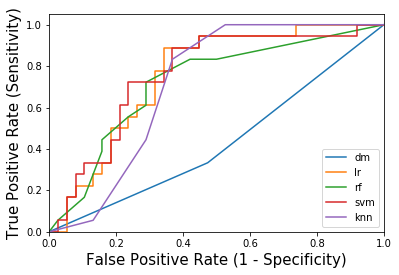

In [18]:
fpr_dm, tpr_dm, thresholds_dm = metrics.roc_curve(Y_train_class, data_ave_last_features['dm_cv_ave_last']['y_pred_prob'][:,1])
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(Y_train_class, data_ave_last_features['lr_cv_ave_last']['y_pred_prob'][:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(Y_train_class, data_ave_last_features['rf_cv_ave_last']['y_pred_prob'][:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(Y_train_class, data_ave_last_features['svm_cv_ave_last']['y_pred_prob'][:,1])
fpr_knn, tpr_knn, thresholds_knn = metrics.roc_curve(Y_train_class, data_ave_last_features['knn_cv_ave_last']['y_pred_prob'][:,1])

# plot model ROC curves
plt.plot(fpr_dm, tpr_dm, label="dm")
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_svm, tpr_svm, label="svm")
plt.plot(fpr_knn, tpr_knn, label="knn")

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0,0.5,'Precision')

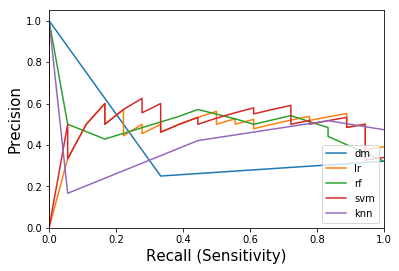

In [19]:
# calculate precision-recall curve
precision_dm, recall_dm, thresholds_pr_dm = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['dm_cv_ave_last']['y_pred_prob'][:,1])
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['lr_cv_ave_last']['y_pred_prob'][:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['rf_cv_ave_last']['y_pred_prob'][:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['svm_cv_ave_last']['y_pred_prob'][:,1])
precision_knn, recall_knn, thresholds_pr_knn = metrics.precision_recall_curve(Y_train_class, data_ave_last_features['knn_cv_ave_last']['y_pred_prob'][:,1])

plt.plot(recall_dm, precision_dm, label='dm')
plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')
plt.plot(recall_knn, precision_knn, label='knn')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [22]:
#scale data
data_scaled = scaler.fit_transform(X_train_ave_last)

#grid search with cv for svm and ave last features
param_grid = {'C':(0.001, 0.01, 0.1, 1, 10), 'decision_function_shape':('ovo','ovr')}
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

svm_base = SVC(kernel='linear', class_weight='balanced', random_state=39)

svm_gs = GridSearchCV(svm_base, param_grid, cv=3, scoring = scoring, refit='f1')
svm_gs.fit(data_scaled, Y_train_class)

print("f1:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_gs, data_scaled, Y_train_class, scoring='roc_auc'))))

print(svm_gs.best_params_)

f1:0.7105263157894736
ROC_AUC:0.8059116809116809
{'C': 0.1, 'decision_function_shape': 'ovo'}


In [23]:
svm_best = SVC(probability=True, kernel='linear', class_weight='balanced', C=.1, decision_function_shape='ovo', random_state=39)
    
print("f1:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='f1'))))
print("ROC_AUC:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='roc_auc'))))
print("Accuracy:"+str(np.average(cross_val_score(svm_best, data_scaled, Y_train_class, scoring='accuracy'))))

f1:0.7105263157894736
ROC_AUC:0.8059116809116809
Accuracy:0.732943469785575


In [ ]:
svm_best.fit(data_scaled, Y_train_class)
print(svm_best.score(data_scaled, Y_train_class))

#scale data
data_scaled_test = scaler.fit_transform(X_test_ave_last)

print('SVM test AUC: {}'.format(svm_best.score(data_scaled_test, Y_test_class)))
test_pred_svm = svm_best.predict(data_scaled_test)
test_pred_prob_svm = svm_best.predict_proba(data_scaled_test)
print(classification_report(Y_test_class, test_pred_svm))
print(confusion_matrix(Y_test_class, test_pred_svm))

In [ ]:
#create new columns for each model's pred prob and the best model's pred class
test['pred_prob_svm'] = test_pred_svm[:,1]
test['class_svm'] = test_pred_prob_svm

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

In [ ]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
    preds = []
    for index, row in dataframe.iterrows():
        if (row['Group'] == 0) & (row[model_name] == 0):
            pred = 'TN'
        if (row['Group'] == 0) & (row[model_name] == 1):
            pred = 'FP'
        if (row['Group'] == 1) & (row[model_name] == 1):
            pred = 'TP'
        if (row['Group'] == 1) & (row[model_name] == 0):
            pred = 'FN'
          
        preds.append(pred)
      
    dataframe[str('pred_' + model_name)] = preds
    return dataframe

### Unsupervised 

In [ ]:
features_cluster = combined_data[['actnp_last_ave', 
                'Inactnp_last_ave', 
               'actTO_last_ave', 
                'avgIII_last_ave']]

# center and scale the data
scaler = StandardScaler()

features_clust_scaled = scaler.fit_transform(features_cluster)

In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(features_clust_scaled)
    scores.append(silhouette_score(features_clust_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=2,random_state=1234)
km2.fit(features_clust_scaled)
combined_data['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
combined_data.groupby('kmeans_2_scaled').mean()

In [ ]:
combined_data.groupby('Group')['kmeans_2_scaled'].value_counts()

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, random_state=1234)
tsne_features = tsne.fit_transform(features_clust_scaled)

print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = combined_data.index)
combined_data = pd.concat([combined_data, tsne_df], axis = 1)
combined_data.head()

In [ ]:
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='Group')
plt.show()
sns.pairplot(x_vars='tsne_0', y_vars='tsne_1', data=combined_data, hue='kmeans_2_scaled')
plt.show()